# Simulating the Kalman Filter by an RNN

In this notebook, a recurrent neural network is trained to predict the true state out of noisy observations. The result is compared to the Kalman Filter. At this stage supervised training is used. That is, access to the true state is required.

Kalman Filtering itself relies on knowledge of the system dynamics. Therefore, the RNN could be a suitable alternative for state estimation in partially observable environments. This architecture will be implemented in the accompanying SAC controller.

In [1]:
import jax
import jax.numpy as jnp
import jax.random as jrandom

import equinox as eqx
import optax

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# import local libraries
from src.OptimalControl.KalmanFilter import KalmanFilter
from environments.linear import Linear_SDI
from src.SACRNN.utilities.ReplayBuffer import ReplayBuffer


## Kalman Filter

### Initialization

Text(0, 0.5, '$\\dot{x}$')

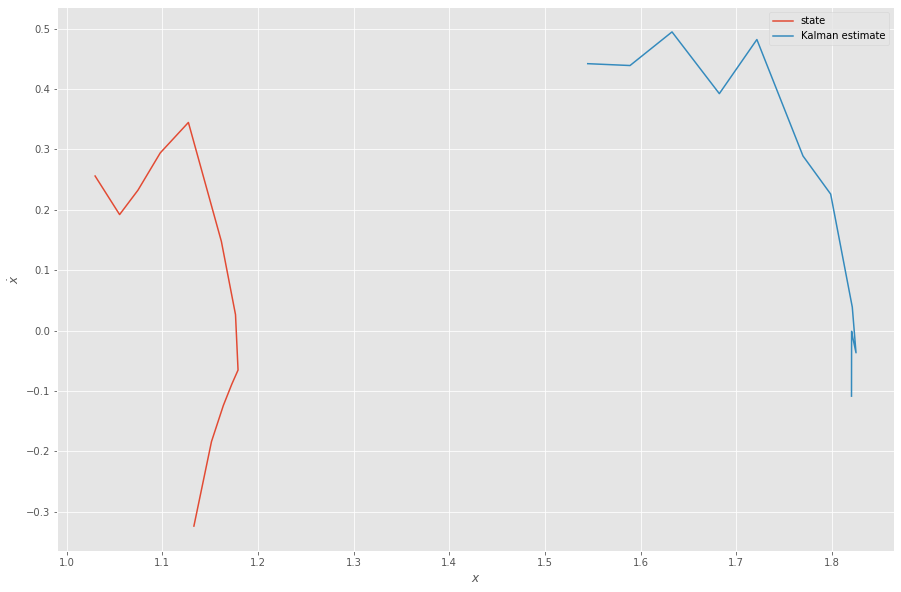

In [2]:
key = jrandom.PRNGKey(0)
N = 12

env = Linear_SDI(end_time=20)
KF = KalmanFilter(env.A, env.B, env.C, env.w, env.v)

X = np.zeros((N, 2))
Y = np.zeros((N, 2))
Xest = np.zeros((N, 2))

x_est = env.reset()
for it in range(N):
    control = jrandom.normal(key, (1,))
    obs, rew, done, _ = env.step(control)

    x_est += KF(x_est, control, obs)*env.dt

    # save
    X[it] = env.state
    Y[it] = obs
    Xest[it] = x_est

    # step
    key, subkey = jrandom.split(key)
    if done:
        x_est = env.reset()

fig, ax = plt.subplots(figsize=(15,10))
ax.plot(X[:,0], X[:,1], label='state')
#ax.plot(Y[:,0], Y[:,1], label='observation')
ax.plot(Xest[:,0], Xest[:,1], label='Kalman estimate')
ax.legend()
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$\dot{x}$')

## RNN

In [3]:
class KalmanFilterRNN(eqx.Module):
    cell: eqx.Module
    hidden_size: int

    def __init__(self, in_size, hidden_size, key):
        self.hidden_size = hidden_size

        self.cell = eqx.nn.GRUCell(in_size, hidden_size, use_bias=False, key=key)
    
    def __call__(self, hidden, control, obs):
        input = jnp.hstack((obs, control))
        out = self.cell(input, hidden)
        return out
    
    def scan(self, control, obs):
        input = jnp.hstack((obs, control))
        hidden = jnp.zeros((self.hidden_size,))
        
        def f(carry, input):
            return self.cell(input, carry), None
        
        out, _ = jax.lax.scan(f, hidden, input)
        
        return out


def get_sample(buffer, batch_size):
    sample = buffer.sample_batch(batch_size)
    obs = sample['traj_obs'] / 5
    control = sample['traj_control']
    target = sample['next_obs'] / 5
    return control, obs, target


@eqx.filter_value_and_grad
def calculate_loss(model, control, obs, target):
    pred = jax.vmap(model.scan)(control, obs)
    return jnp.mean((pred - target)**2)


@eqx.filter_jit
def apply_step(model, optimizer, opt_state, control, obs, target):
    loss, grads = calculate_loss(model, control, obs, target)
    updates, opt_state = optimizer.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss



### Generate training data

In [4]:
key = jrandom.PRNGKey(0)
N = 2000
history_size = 12

env = Linear_SDI(end_time=20)
env.boundary = True
env.min = jnp.array([-5, -5])
env.max = jnp.array([5, 5])

buffer = ReplayBuffer(10000, 2, key, history_size=history_size)

env.reset()
for it in range(N):
    control = jrandom.normal(key, (1,))
    obs, rew, done, _ = env.step(control)
    buffer.feed(obs, control, rew, env.state, done)     # just need a place to store the true state

    # step
    key, subkey = jrandom.split(key)
    if done:
        x_est = env.reset()


### Train

In [5]:
key = jrandom.PRNGKey(0)
learning_rate = 3e-2
batch_size = 100

model = KalmanFilterRNN(3, 2, key=key)
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(model)

for step in range(500):
    control, obs, target = get_sample(buffer, batch_size)
    model, opt_state, loss = apply_step(model, optimizer, opt_state, control, obs, target)
    print(f'step={step}\tloss={loss}')



step=0	loss=0.395077645778656
step=1	loss=0.3056981563568115
step=2	loss=0.3314950466156006
step=3	loss=0.2505243718624115
step=4	loss=0.30500614643096924
step=5	loss=0.25266799330711365
step=6	loss=0.24403806030750275
step=7	loss=0.21721164882183075
step=8	loss=0.2108176350593567
step=9	loss=0.18505452573299408
step=10	loss=0.16844196617603302
step=11	loss=0.13848917186260223
step=12	loss=0.1275017261505127
step=13	loss=0.146908700466156
step=14	loss=0.12537987530231476
step=15	loss=0.11380594968795776
step=16	loss=0.11247292160987854
step=17	loss=0.11259885877370834
step=18	loss=0.11073116213083267
step=19	loss=0.08801021426916122
step=20	loss=0.08538226783275604
step=21	loss=0.07098682969808578
step=22	loss=0.06788890808820724
step=23	loss=0.08834274858236313
step=24	loss=0.07538425177335739
step=25	loss=0.054541610181331635
step=26	loss=0.06366642564535141
step=27	loss=0.05134758725762367
step=28	loss=0.06492362916469574
step=29	loss=0.05716966465115547
step=30	loss=0.0509640201926

### Test

Text(0, 0.5, '$\\dot{x}$')

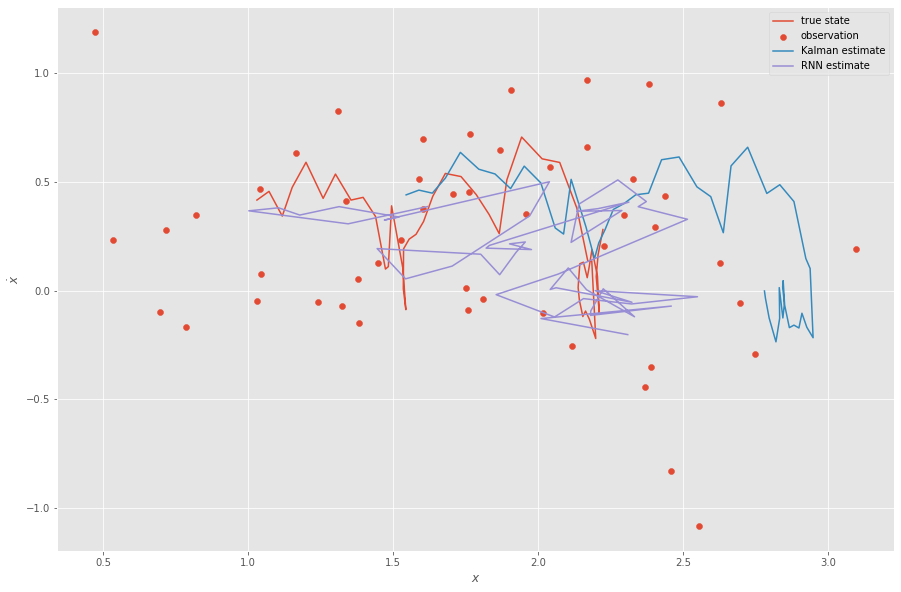

In [6]:
key = jrandom.PRNGKey(2)
N = 50

env = Linear_SDI(end_time=20)
env.boundary = True
env.min = jnp.array([-5, -5])
env.max = jnp.array([5, 5])

RNN_KF = model
KF = KalmanFilter(env.A, env.B, env.C, env.w, env.v)

X = np.zeros((N, 2))
Y = np.zeros((N, 2))
Xkf = np.zeros((N, 2))
Xrnn = np.zeros((N, 2))

x_kf = env.reset()
x_hid = x_kf / 5
for it in range(N):
    control = jrandom.normal(key, (1,))
    obs, rew, done, _ = env.step(control)
    
    x_kf += KF(x_kf, control, obs)*env.dt
    x_hid = RNN_KF(x_hid, control, obs / 5)

    # save
    X[it] = env.state
    Y[it] = obs
    Xkf[it] = x_kf
    Xrnn[it] = x_hid*5

    # step
    key, subkey = jrandom.split(key)
    if done:
        x_est = env.reset()

fig, ax = plt.subplots(figsize=(15,10))
ax.plot(X[:,0], X[:,1], label='true state')
ax.scatter(Y[:,0], Y[:,1], label='observation')
ax.plot(Xkf[:,0], Xkf[:,1], label='Kalman estimate')
ax.plot(Xrnn[:,0], Xrnn[:,1], label='RNN estimate')
ax.legend()
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$\dot{x}$')